# DBE 분석결과 정리

In [1]:
import torch
import pandas as pd
from dynamic_bernoulli_embeddings.analysis import DynamicEmbeddingAnalysis
from dynamic_bernoulli_embeddings.training import train_model
from gensim.corpora import Dictionary
from tqdm import tqdm
from collections import Counter
import math
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import chain

In [5]:
# 데이터셋 로드
dataset = pd.read_pickle('./230221_chosun_dataset.pkl')

In [2]:
# DBE 학습 모델 로드
chosun_model = torch.load('./230222_chosun_DBE.pt')

In [3]:
# 학습 대상 단어 딕셔너리 로드
chosun_dict = Dictionary.load('./chosun_1000_dictionary')

In [4]:
# chosun_emb에 학습 완료 모델과 딕셔너리로 분석 결과 할당
chosun_emb = DynamicEmbeddingAnalysis(chosun_model.get_embeddings(), chosun_dict.token2id)

In [ ]:
# 데이터 범위 시작년도인 1920과 기간인 20을 변수로 추가
min_year = 1920
max_time = 20

In [6]:
# 연도별 타겟 단어의 상위 유사어 추출하기 함수
def time_neigh(emb,target, min_year,max_time, top_n):
    over_time = {}
    for i in range(0, max_time + 1, 1):
        col = str(min_year + i)
        over_time[col] = emb.neighborhood(target, i, top_n)
    return pd.DataFrame(over_time)

In [7]:
# 주요 타겟 개념단어군(민족, 국민, 국가 이외 단어 포함)
target_words = ['민족', '국민', '국가', '독립', '문화', '문명',\
                '인민', '신민' ,'노동자', '사회', '지주', '경제', '계급', '운동',\
                '청년', '생활', '태도', '문학']

### 1. 단어별 부침(drift) : 1920 vs 1940

In [11]:
# 단어별 부침 결과 정리
chosun_drift = pd.DataFrame(chosun_emb.absolute_drift(n=100000),columns=['drift','단어'])
chosun_drift.to_excel('./results/chosun_drift.xlsx',index=None) # 결과 저장

In [12]:
# 분석 대상 모든 단어에 대해 결과 확인
len(chosun_drift)

7625

In [14]:
# 모든 단어의 변화량 기술통계량
chosun_drift.describe()

,drift
count,7625.000000
mean,0.354933
std,0.105171
min,0.123086
25%,0.278821
50%,0.341120
75%,0.412766
max,1.071474


<AxesSubplot: >

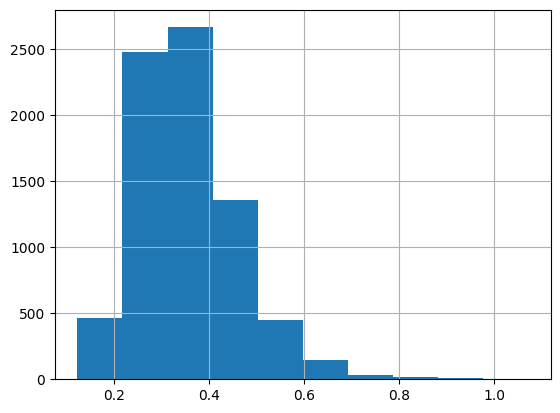

In [15]:
# 모든 단어 부침 히스토그램
chosun_drift['drift'].hist()

### b. 연도별 타겟 단어의 주요 유사어 정리

In [9]:
# 타겟 단어들의 연도별 상위 유사어 엑셀 파일로 저장
for idx, target_word in tqdm(enumerate(target_words)):
    try:
        df = time_neigh(chosun_emb,target_word,1920,20,100)
    except KeyError:
        print(f'{target_word} 없음')
        continue
    if idx ==0:
        with pd.ExcelWriter(f'./results/chosun_time_neigh_v2.xlsx',mode='w') as writer:
            df.to_excel(writer,sheet_name=target_word,index=None)
    else:
        with pd.ExcelWriter(f'./results/chosun_time_neigh_v2.xlsx',mode='a') as writer:
            df.to_excel(writer,sheet_name=target_word,index=None)

18it [00:11,  1.57it/s]


In [30]:
df = time_neigh(chosun_emb,'민족',1920,20,30)

In [31]:
# 1923과 1924 서로 다른 단어 (1923에만 존재)
print(set(df['1923'].map(lambda x:x[0]).tolist()) - set(df['1924'].map(lambda x:x[0]).tolist()))

# 1923과 1924 서로 다른 단어 (1924에만 존재)
print(set(df['1924'].map(lambda x:x[0]).tolist()) - set(df['1923'].map(lambda x:x[0]).tolist()))

{'동포', '족', '하물며', '여성'}
{'대국', '영토', '정치', '결합'}


In [32]:
# 1924과 1925 서로 다른 단어 (1924에만 존재)
print(set(df['1924'].map(lambda x:x[0]).tolist()) - set(df['1925'].map(lambda x:x[0]).tolist()))

# 1924과 1925 서로 다른 단어 (1925에만 존재)
print(set(df['1925'].map(lambda x:x[0]).tolist()) - set(df['1924'].map(lambda x:x[0]).tolist()))

{'정치', '문명', '영토', '대국', '사회'}
{'의식', '프롤레타리아', '계급', '개념', '자본주의'}


In [33]:
# 1935과 1926 서로 다른 단어 (1935에만 존재)
print(set(df['1935'].map(lambda x:x[0]).tolist()) - set(df['1936'].map(lambda x:x[0]).tolist()))

# 1935과 1936 서로 다른 단어 (1936에만 존재)
print(set(df['1936'].map(lambda x:x[0]).tolist()) - set(df['1935'].map(lambda x:x[0]).tolist()))

{'해방', '진실로', '신앙', '자아', '정열', '하물며', '역사'}
{'영토', '독립', '독일인', '군벌', '권력', '자본주의', '일국'}


### c. 두 단어의 시계열에 따른 유사도 추이

In [8]:
def time_similarity(main_word, alter_words, max_time):
    simil = {}
    for word in alter_words:
        simil[word] = [t[1] for i in range(0, max_time + 1, 1) for t in chosun_emb.neighborhood(main_word, i, 10000) if t[0]==word]
    return simil

In [9]:
nation = pd.DataFrame.from_dict(time_similarity('민족',['인종','국가','국민','국어','언어','민중','인민','백성','신민','동포','나라','조선','독립','사회주의','자본주의','문학','문명','문화','근대'],max_time),orient='index').T
nation.index = list(range(1920,1941,1))
nation.to_excel('./results/민족_time_similarity.xlsx')
nation

,인종,국가,국민,국어,언어,민중,인민,백성,신민,동포,나라,조선,독립,사회주의,자본주의,문학,문명,문화,근대
1920,0.723407,0.718545,0.725942,0.580181,0.600789,0.762374,0.549115,0.530646,0.535970,0.714033,0.698633,0.486047,0.513326,0.609671,0.650726,0.603641,0.684650,0.768544,0.618743
1921,0.734278,0.706472,0.716054,0.572192,0.605747,0.761695,0.544998,0.523368,0.523170,0.704524,0.691126,0.480307,0.533304,0.601330,0.643602,0.597696,0.677413,0.772325,0.612365
1922,0.741638,0.720589,0.729072,0.586792,0.626866,0.774305,0.571482,0.548377,0.539964,0.692861,0.703566,0.474719,0.544742,0.620355,0.657398,0.613968,0.694364,0.760574,0.628816
1923,0.745577,0.722941,0.717464,0.588585,0.633345,0.770073,0.577178,0.563495,0.540640,0.681316,0.703653,0.458865,0.560054,0.637427,0.660577,0.619370,0.692773,0.747331,0.632680
1924,0.756248,0.743770,0.731984,0.580146,0.635555,0.764326,0.584645,0.547839,0.533987,0.655848,0.691177,0.446047,0.568831,0.663652,0.676716,0.613812,0.677625,0.740683,0.636322
1925,0.770822,0.753079,0.739095,0.603228,0.660359,0.783058,0.599380,0.568524,0.548837,0.652617,0.698196,0.500499,0.621807,0.691642,0.699693,0.655074,0.687898,0.747763,0.660368
1926,0.762042,0.733897,0.717146,0.572665,0.656999,0.768291,0.612390,0.566090,0.521969,0.651361,0.676759,0.472270,0.632762,0.689080,0.691982,0.650411,0.656959,0.732176,0.641483
1927,0.762453,0.728878,0.679589,0.581755,0.670925,0.762247,0.625356,0.576058,0.526652,0.644056,0.673025,0.465366,0.645224,0.692029,0.692797,0.662366,0.648286,0.736281,0.638432
1928,0.754982,0.726968,0.651440,0.576913,0.686930,0.769760,0.625556,0.577853,0.536178,0.623199,0.665811,0.467842,0.664531,0.701193,0.694897,0.673272,0.654147,0.738940,0.643453
1929,0.755992,0.726712,0.631045,0.586718,0.704050,0.765313,0.632762,0.572945,0.545058,0.618954,0.660790,0.482661,0.653590,0.704860,0.692998,0.702518,0.653741,0.752057,0.650651


In [14]:
nation.describe()

,인종,국가,국민,국어,언어,민중,인민,백성,신민,동포,나라,조선,독립,사회주의,자본주의,문학,문명,문화,근대
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.771366,0.729770,0.677867,0.569258,0.684914,0.758096,0.610860,0.588064,0.557830,0.637931,0.705246,0.450264,0.639602,0.695576,0.688216,0.681129,0.667499,0.777106,0.632897
std,0.023622,0.012653,0.036852,0.024876,0.043593,0.021233,0.031116,0.036800,0.026361,0.035692,0.032586,0.044809,0.064660,0.045331,0.021364,0.048588,0.014871,0.031405,0.014710
min,0.723407,0.706472,0.623964,0.504841,0.600789,0.708075,0.544998,0.523368,0.521969,0.589251,0.655040,0.352727,0.513326,0.601330,0.643602,0.597696,0.644515,0.732176,0.600363
25%,0.755992,0.722554,0.653967,0.565943,0.656999,0.761372,0.587386,0.563495,0.536178,0.610126,0.676759,0.429957,0.621807,0.689080,0.679482,0.650411,0.656724,0.747763,0.628813
50%,0.770822,0.728878,0.662172,0.576722,0.701013,0.765313,0.624160,0.577853,0.552742,0.632525,0.698633,0.465366,0.645373,0.704860,0.691982,0.702518,0.661642,0.772325,0.633231
75%,0.791134,0.737137,0.717146,0.581755,0.718328,0.770073,0.632762,0.626747,0.581945,0.652617,0.732246,0.482661,0.671287,0.719575,0.699693,0.712303,0.679102,0.802200,0.643453
max,0.801989,0.753079,0.739095,0.603228,0.737592,0.783058,0.656046,0.639207,0.601250,0.714033,0.764465,0.500499,0.735496,0.755256,0.724100,0.741108,0.694364,0.826394,0.660368


In [9]:
nation_국민 = pd.DataFrame.from_dict(time_similarity('국민',['인종','국가','민족','국어','언어','민중','인민','백성','신민','동포','나라','조선','독립','사회주의','자본주의','문학','문명','문화','근대'],max_time),orient='index').T
nation_국민.index = list(range(1920,1941,1))
nation_국민.to_excel('./results/국민_time_similarity.xlsx')
nation_국민

,인종,국가,민족,국어,언어,민중,인민,백성,신민,동포,나라,조선,독립,사회주의,자본주의,문학,문명,문화,근대
1920,0.602574,0.784659,0.725942,0.612748,0.567228,0.760271,0.674537,0.489009,0.580416,0.532808,0.670819,0.389828,0.468932,0.669306,0.653631,0.578564,0.557866,0.659082,0.666335
1921,0.600370,0.773529,0.716054,0.585535,0.545424,0.751503,0.656574,0.461349,0.552412,0.512218,0.654242,0.380422,0.475244,0.650343,0.636399,0.550943,0.549579,0.644610,0.642078
1922,0.599999,0.786407,0.729072,0.604470,0.568391,0.760192,0.672917,0.492578,0.573790,0.516586,0.654642,0.396020,0.490904,0.656230,0.637971,0.571026,0.575386,0.642827,0.647278
1923,0.591540,0.786368,0.717464,0.592880,0.551909,0.747835,0.673177,0.503016,0.562795,0.492036,0.638703,0.360838,0.508736,0.655780,0.616545,0.560271,0.555273,0.618155,0.627521
1924,0.608961,0.792057,0.731984,0.584814,0.553852,0.739330,0.687336,0.512255,0.570096,0.506041,0.635993,0.390482,0.535652,0.678891,0.633561,0.570389,0.565366,0.627215,0.637967
1925,0.602633,0.799270,0.739095,0.588729,0.574869,0.740092,0.700162,0.534794,0.585727,0.514125,0.628152,0.403877,0.575844,0.677925,0.644928,0.601094,0.587141,0.636154,0.651527
1926,0.584845,0.795540,0.717146,0.576232,0.586928,0.751620,0.718033,0.554855,0.586680,0.538126,0.628742,0.395189,0.611098,0.682690,0.638224,0.607026,0.569160,0.632566,0.632067
1927,0.531932,0.778572,0.679589,0.553027,0.583658,0.746715,0.726804,0.531739,0.570623,0.507061,0.613534,0.373607,0.619685,0.650418,0.604367,0.582293,0.533342,0.595505,0.596784
1928,0.508270,0.758406,0.651440,0.526643,0.568690,0.757581,0.725571,0.523457,0.566548,0.489988,0.593340,0.372094,0.635764,0.650909,0.591204,0.572164,0.516524,0.598934,0.587544
1929,0.500273,0.757188,0.631045,0.513410,0.552089,0.750840,0.737541,0.525337,0.577398,0.502383,0.591975,0.365638,0.632022,0.648723,0.566399,0.558968,0.484374,0.588398,0.560966


In [10]:
state = pd.DataFrame.from_dict(time_similarity('국가',['인종','국민','민족','국어','언어','민중','인민','백성','신민','동포','나라','조선','독립','사회주의','자본주의','문학','문명','문화','근대'],max_time),orient='index').T
state.index = list(range(1920,1941,1))
state.to_excel('./results/국가_time_similarity.xlsx')
state

,인종,국민,민족,국어,언어,민중,인민,백성,신민,동포,나라,조선,독립,사회주의,자본주의,문학,문명,문화,근대
1920,0.596068,0.784659,0.718545,0.500345,0.540558,0.663124,0.605485,0.498473,0.509744,0.467314,0.681267,0.383333,0.408015,0.708533,0.791213,0.483921,0.600951,0.630472,0.672452
1921,0.587620,0.773529,0.706472,0.493018,0.526843,0.660615,0.579181,0.491061,0.499775,0.453278,0.669911,0.389098,0.426502,0.698008,0.782626,0.472574,0.594160,0.624463,0.660047
1922,0.605180,0.786407,0.720589,0.505610,0.552424,0.667447,0.613964,0.515423,0.521058,0.437338,0.675636,0.380420,0.466964,0.715129,0.785340,0.485786,0.599439,0.612715,0.674459
1923,0.615711,0.786368,0.722941,0.514822,0.554108,0.663628,0.629799,0.537653,0.527586,0.438927,0.685205,0.371727,0.507236,0.726195,0.793136,0.493962,0.608819,0.601047,0.688603
1924,0.635932,0.792057,0.743770,0.511456,0.563009,0.642668,0.626320,0.542842,0.534344,0.450905,0.678862,0.410669,0.541449,0.735286,0.799519,0.500575,0.618556,0.613762,0.695619
1925,0.639717,0.799270,0.753079,0.522402,0.567921,0.634974,0.644672,0.560229,0.552262,0.440370,0.677557,0.443580,0.605308,0.743978,0.802263,0.530169,0.635291,0.624559,0.702556
1926,0.627627,0.795540,0.733897,0.514834,0.572353,0.653989,0.673115,0.608948,0.562827,0.483258,0.689279,0.443705,0.647253,0.753866,0.810986,0.545632,0.638293,0.632498,0.703013
1927,0.608908,0.778572,0.728878,0.515407,0.576222,0.649881,0.688276,0.615065,0.576749,0.464990,0.697837,0.442647,0.678765,0.742344,0.801836,0.538144,0.630063,0.622305,0.697806
1928,0.619222,0.758406,0.726968,0.504822,0.584790,0.663484,0.694308,0.617470,0.589009,0.446333,0.700454,0.443395,0.699250,0.753061,0.805984,0.545343,0.634365,0.636266,0.700650
1929,0.618008,0.757188,0.726712,0.499137,0.574642,0.678266,0.706691,0.611926,0.595466,0.468995,0.706540,0.454456,0.695228,0.757751,0.794970,0.542438,0.619970,0.641580,0.687323


### d. 단어 변곡점

In [10]:
chosun_change_point = pd.DataFrame(chosun_emb.change_points(n=1000000),columns=['연도','단어','change'])
chosun_change_point['연도'] = chosun_change_point['연도'] + 1920
chosun_change_point
chosun_change_point.to_excel('./results/chosun_change_point.xlsx',index=None)

,연도,단어,change
0,1931,동경,0.329711
1,1937,지나,0.269213
2,1931,발,0.268887
3,1933,오전,0.258635
4,1938,일본,0.251103
...,...,...,...
152495,1921,인플레,0.003248
152496,1923,드라마,0.003227
152497,1921,공습,0.003038
152498,1921,헌금,0.002832


In [46]:
# 타겟단어 변곡점
chosun_change_point_target = chosun_change_point[chosun_change_point['단어'].isin(target_words)]
chosun_change_point_target = chosun_change_point_target.sort_values(by=['단어','change'],ascending=False).reset_index(drop=True)

In [53]:
# 타겟단어 변곡점 엑셀로 저장
for idx, target_word in tqdm(enumerate(target_words)):
    df = chosun_change_point_target[chosun_change_point_target['단어']==target_word].sort_values(by=['연도'])
    if idx ==0:
        with pd.ExcelWriter(f'./results/chosun_change_point_target.xlsx',mode='w') as writer:
            df.to_excel(writer,sheet_name=target_word,index=None)
    else:
        with pd.ExcelWriter(f'./results/chosun_change_point_target.xlsx',mode='a') as writer:
            df.to_excel(writer,sheet_name=target_word,index=None)

17it [00:00, 33.28it/s]


In [42]:
# 타겟단어 변곡점(change max 추출)
chosun_change_max_idx = chosun_change_point_target.groupby(['단어'])['change'].idxmax().tolist()
chosun_change_point_target.iloc[chosun_change_max_idx].sort_values('연도')

,연도,단어,change
200,1922,문명,0.099094
240,1924,노동자,0.140479
220,1925,독립,0.140275
120,1927,사회,0.124653
100,1929,생활,0.153078
80,1930,운동,0.122368
20,1931,청년,0.133598
0,1934,태도,0.106004
180,1934,문학,0.109125
300,1936,계급,0.132456


In [16]:
# 전체 단어 연도별 변동 평균
chosun_change_point.groupby(['연도'])['change'].mean().to_excel('./results/chosun_change_point_모든단어 연도별 평균.xlsx')
chosun_change_point.groupby(['연도'])['change'].mean()

연도
1921    0.038290
1922    0.040592
1923    0.040857
1924    0.052756
1925    0.055464
1926    0.056693
1927    0.057958
1928    0.057292
1929    0.058819
1930    0.063017
1931    0.063457
1932    0.061708
1933    0.061752
1934    0.062912
1935    0.063467
1936    0.064170
1937    0.064877
1938    0.063991
1939    0.060804
1940    0.055608
Name: change, dtype: float32

In [43]:
chosun_change_point_des = chosun_change_point.groupby(['단어'])['change'].describe()

In [71]:
# 변화량(표준편차)가 가장 큰 단어들
chosun_change_point_des.sort_values(by=['cv'],ascending=False).to_excel('./results/chosun_change_point_des_all.xlsx')
chosun_change_point_des.sort_values(by=['cv'],ascending=False)

,count,mean,std,min,25%,50%,75%,max,cv
단어,,,,,,,,,
에디오피아,20.0,0.053361,0.051635,0.003338,0.013599,0.035452,0.069777,0.177964,0.967666
노픈,20.0,0.035419,0.031467,0.003682,0.010513,0.025161,0.052031,0.116334,0.888429
공습,20.0,0.039019,0.033269,0.003038,0.015711,0.034833,0.052274,0.147622,0.852644
링크,20.0,0.038619,0.031474,0.004451,0.013765,0.029165,0.059908,0.116195,0.814971
헌금,20.0,0.041833,0.034091,0.002832,0.019845,0.032982,0.057861,0.142327,0.814922
...,...,...,...,...,...,...,...,...,...
돌아오다,20.0,0.072477,0.005582,0.061986,0.068587,0.071522,0.076806,0.082119,0.077016
대하다,20.0,0.106440,0.008136,0.090508,0.102127,0.107039,0.111551,0.122663,0.076436
만,20.0,0.110016,0.008018,0.094010,0.105854,0.109651,0.115899,0.120608,0.072884


In [67]:
chosun_change_point_target.groupby(['단어'])['change'].describe().to_excel('./results/chosun_change_point_des.xlsx')
chosun_change_point_target.groupby(['단어'])['change'].describe().sort_values(by=['std'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
단어,,,,,,,,
경제,20.0,0.114122,0.036767,0.052318,0.092791,0.103431,0.139151,0.185984
문학,20.0,0.080743,0.022173,0.029571,0.071731,0.081455,0.099696,0.109125
독립,20.0,0.100658,0.021494,0.069765,0.083919,0.097349,0.117925,0.140275
계급,20.0,0.081951,0.021467,0.052531,0.066556,0.078403,0.092505,0.132456
국민,20.0,0.106962,0.021365,0.074717,0.093923,0.106937,0.118304,0.159043
생활,20.0,0.103783,0.020101,0.081394,0.089371,0.098054,0.110585,0.153078
문화,20.0,0.086033,0.018518,0.052917,0.077670,0.085115,0.090527,0.137907
민족,20.0,0.087672,0.017057,0.061463,0.077883,0.083928,0.094634,0.131000
인민,20.0,0.094040,0.016233,0.069130,0.079770,0.092060,0.107428,0.121850


### e. 빈도 분석

In [5]:
def extract_keywords(vector, min_df, series):
    if vector =='tf':
        vectorizer = CountVectorizer(analyzer='word',
                             lowercase=False,
                             tokenizer=None,
                             preprocessor=None,
                            #  stop_words=['NNG'],
                            #  token_pattern = r'(?u)\b\w\w+(?:\/)?\w+\b',
                             min_df=min_df, # 최소 N개 문서(단락)에서 등장해야 함
                             ngram_range=(1,1) #bigram까지
                             )
    else:
        vectorizer = TfidfVectorizer(analyzer='word',
                             lowercase=False,
                             tokenizer=None,
                             preprocessor=None,
                            #  stop_words=['NNG'],
                            #  token_pattern = r'(?u)\b\w\w+(?:\/)?\w+\b',
                             min_df=min_df, 
                             ngram_range=(1,1),
                             smooth_idf=True)
    vector = vectorizer.fit_transform(series.astype(str))
    scores = vector.toarray().sum(axis=0)
    idx = np.argsort(-scores)
    scores = scores[idx]
    vocab = np.array(vectorizer.get_feature_names_out())[idx]
    return vocab, scores

In [12]:
# 상위 n개 Unigram 확인
tokens = chain(*dataset['bow'].tolist())
cnt = Counter(tokens)
cnt.most_common(100) # 상위 N개

[('이다', 7144643),
 ('일', 5212058),
 ('것', 3289160),
 ('이', 2902724),
 ('그', 2035409),
 ('되다', 1834040),
 ('전', 1730280),
 ('삼', 1724262),
 ('되', 1678353),
 ('원', 1549585),
 ('십', 1532483),
 ('잇다', 1530539),
 ('하야', 1450877),
 ('있다', 1318313),
 ('오', 1236874),
 ('시', 1190272),
 ('사', 1176553),
 ('중', 1143819),
 ('적', 1142110),
 ('대', 1054376),
 ('보다', 995629),
 ('수', 959044),
 ('팔', 952267),
 ('등', 900053),
 ('칠', 881959),
 ('구', 881242),
 ('씨', 870526),
 ('들', 841276),
 ('명', 818569),
 ('한', 810896),
 ('동', 797168),
 ('백', 796153),
 ('바', 789546),
 ('월', 769355),
 ('데', 722287),
 ('조선', 709781),
 ('가다', 708046),
 ('없다', 671631),
 ('안', 663073),
 ('만', 639258),
 ('말', 637433),
 ('오다', 613748),
 ('년', 608481),
 ('천', 603555),
 ('륙', 577242),
 ('제', 557052),
 ('여', 547882),
 ('분', 545839),
 ('대하다', 539069),
 ('상', 538551),
 ('저', 535854),
 ('후', 529533),
 ('사람', 516249),
 ('나', 496654),
 ('군', 482971),
 ('성', 472623),
 ('각', 467617),
 ('문제', 467243),
 ('부', 465410),
 ('자', 464903),
 ('육',

In [15]:
chosun_tf_vocab, chosun_tf_scores = extract_keywords('tf',2000, dataset.loc[dataset['publisher']=='chosun','bow']) # 최소 2000개의 문서 이상에서 쓰인 단어만 필터링
chosun_tfidf_vocab, chosun_tfidf_scores = extract_keywords('tfidf',2000, dataset.loc[dataset['publisher']=='chosun','bow'])

In [17]:
###TF, TF-IDF 단어 테이블 정리###
chosun_tf_tfidf_vocab = pd.DataFrame(list(zip(chosun_tf_vocab,chosun_tf_scores,chosun_tfidf_vocab,chosun_tfidf_scores))[:200],columns=['TF_Word','TF','TFIDF_Word','TFIDF'])
chosun_tf_tfidf_vocab.to_excel('./results/조선일보_tf_tfidf_vocab.xlsx')
chosun_tf_tfidf_vocab

,TF_Word,TF,TFIDF_Word,TFIDF
0,이다,3280053,이다,65870.857937
1,있다,1280240,있다,33267.863194
2,되다,892597,되다,26558.858605
3,보다,474904,대하다,16977.213300
4,대하다,434600,조선,16299.888706
...,...,...,...,...
195,이번,44830,본보,3342.789405
196,반대,44782,연맹,3341.235982
197,수상,44506,또는,3333.442382
198,시작,44402,요구,3326.939188
